<a href="https://colab.research.google.com/github/Shobana0608/Learnbay-Project/blob/main/knn_document_retrieval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# K-Nearest Neighbors Document Retrieval System

This notebook demonstrates how to build a document retrieval system using K-Nearest Neighbors (KNN) algorithm. We'll use the 20 Newsgroups dataset, which contains approximately 20,000 newsgroup documents across 20 different categories.

## Overview
- **Dataset**: 20 Newsgroups from sklearn.datasets
- **Preprocessing**: Tokenization, stopword removal, and text cleaning
- **Vectorization**: TF-IDF (Term Frequency-Inverse Document Frequency)
- **Similarity**: KNN with cosine distance for finding similar documents
- **Evaluation**: Query examples and similarity analysis

## 1. Import Required Libraries

We'll import all necessary libraries for data processing, machine learning, and visualization.

In [1]:
# Data manipulation and analysis
import numpy as np
import pandas as pd

# Machine learning libraries
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity

# Text preprocessing
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Download NLTK data (run once)
import nltk
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)

# Display settings
pd.set_option('display.max_colwidth', 100)
plt.style.use('default')

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Dataset Loading and Exploration

We'll load the 20 Newsgroups dataset, which is a collection of newsgroup documents. For efficiency, we'll use a subset of categories and limit the number of documents.

In [2]:
# Define categories for focused analysis (subset for faster processing)
categories = [
    'alt.atheism',
    'comp.graphics',
    'comp.os.ms-windows.misc',
    'comp.sys.ibm.pc.hardware',
    'rec.autos',
    'rec.motorcycles',
    'sci.space',
    'talk.politics.misc'
]

# Load the dataset
print("Loading 20 Newsgroups dataset...")
newsgroups_data = fetch_20newsgroups(
    subset='all',
    categories=categories,
    shuffle=True,
    random_state=42,
    remove=('headers', 'footers', 'quotes')  # Remove metadata for cleaner text
)

# Create a DataFrame for easier manipulation
df = pd.DataFrame({
    'text': newsgroups_data.data,
    'category': [newsgroups_data.target_names[i] for i in newsgroups_data.target],
    'target': newsgroups_data.target
})

print(f"Dataset loaded successfully!")
print(f"Total documents: {len(df)}")
print(f"Categories: {len(categories)}")
print(f"\nCategory distribution:")
print(df['category'].value_counts())

Loading 20 Newsgroups dataset...
Dataset loaded successfully!
Total documents: 7487
Categories: 8

Category distribution:
category
rec.motorcycles             996
rec.autos                   990
sci.space                   987
comp.os.ms-windows.misc     985
comp.sys.ibm.pc.hardware    982
comp.graphics               973
alt.atheism                 799
talk.politics.misc          775
Name: count, dtype: int64


## 3. Data Exploration and Sample Documents

Let's examine some sample documents to understand the data structure and content.

In [3]:
# Display basic statistics
print("Dataset Overview:")
print(f"Shape: {df.shape}")
print(f"\nText length statistics:")
df['text_length'] = df['text'].str.len()
print(df['text_length'].describe())

# Show sample documents from different categories
print("\n" + "="*80)
print("SAMPLE DOCUMENTS")
print("="*80)

for category in df['category'].unique()[:3]:  # Show 3 categories
    sample_doc = df[df['category'] == category].iloc[0]
    print(f"\nCategory: {category}")
    print("-" * 50)
    print(f"Text preview: {sample_doc['text'][:300]}...")
    print(f"Full length: {len(sample_doc['text'])} characters")

Dataset Overview:
Shape: (7487, 3)

Text length statistics:
count      7487.000000
mean       1131.098304
std        4531.956264
min           0.000000
25%         219.000000
50%         443.000000
75%         860.000000
max      158791.000000
Name: text_length, dtype: float64

SAMPLE DOCUMENTS

Category: sci.space
--------------------------------------------------
Text preview: There is an interesting opinion piece in the business section of today's
LA Times (Thursday April 15, 1993, p. D1).  I thought I'd post it to
stir up some flame wars - I mean reasoned debate.  Let me preface it by
saying that I largely agree that the "Space Age" in the romantic sense
of several deca...
Full length: 3597 characters

Category: rec.motorcycles
--------------------------------------------------
Text preview: 

The answer is obvious: ZX-11 D....
Full length: 33 characters

Category: alt.atheism
--------------------------------------------------
Text preview: 
Did you check with the Afghans before po

## 4. Text Preprocessing

We'll implement comprehensive text preprocessing including:
- Lowercasing
- Removing special characters and numbers
- Tokenization
- Stopword removal
- Optional stemming

In [4]:
# Initialize preprocessing tools
nltk.download('punkt_tab') # This line caused the error
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_text(text, use_stemming=True):
    """
    Comprehensive text preprocessing function

    Args:
        text (str): Input text to preprocess
        use_stemming (bool): Whether to apply stemming

    Returns:
        str: Preprocessed text
    """
    # Convert to lowercase
    text = text.lower()

    # Remove special characters, numbers, and extra whitespace
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    # Tokenization
    tokens = word_tokenize(text)

    # Remove stopwords and short words
    tokens = [token for token in tokens if token not in stop_words and len(token) > 2]

    # Optional stemming
    if use_stemming:
        tokens = [stemmer.stem(token) for token in tokens]

    return ' '.join(tokens)

# Apply preprocessing to the dataset
print("Preprocessing documents...")
df['processed_text'] = df['text'].apply(lambda x: preprocess_text(x, use_stemming=True))

# Remove empty documents after preprocessing
df = df[df['processed_text'].str.len() > 0].reset_index(drop=True)

print(f"Preprocessing complete!")
print(f"Documents after preprocessing: {len(df)}")

# Show preprocessing example
print("\n" + "="*80)
print("PREPROCESSING EXAMPLE")
print("="*80)
sample_idx = 0
print(f"Original text (first 200 chars):\n{df.iloc[sample_idx]['text'][:200]}...")
print(f"\nProcessed text (first 200 chars):\n{df.iloc[sample_idx]['processed_text'][:200]}...")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Preprocessing documents...
Preprocessing complete!
Documents after preprocessing: 7249

PREPROCESSING EXAMPLE
Original text (first 200 chars):
There is an interesting opinion piece in the business section of today's
LA Times (Thursday April 15, 1993, p. D1).  I thought I'd post it to
stir up some flame wars - I mean reasoned debate.  Let me ...

Processed text (first 200 chars):
interest opinion piec busi section today time thursday april thought post stir flame war mean reason debat let prefac say larg agre space age romant sens sever decad ago project like space station mis...


## 5. TF-IDF Vectorization

We'll convert the preprocessed text documents into numerical vectors using TF-IDF (Term Frequency-Inverse Document Frequency). This creates a sparse matrix where each document is represented by the importance of words it contains.

In [5]:
# Initialize TF-IDF Vectorizer with optimized parameters
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,        # Limit vocabulary size for efficiency
    min_df=2,                 # Ignore terms that appear in less than 2 documents
    max_df=0.8,               # Ignore terms that appear in more than 80% of documents
    ngram_range=(1, 2),       # Use unigrams and bigrams
    sublinear_tf=True         # Apply sublinear scaling to term frequencies
)

# Fit and transform the documents
print("Creating TF-IDF vectors...")
tfidf_matrix = tfidf_vectorizer.fit_transform(df['processed_text'])

print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")
print(f"Vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")
print(f"Matrix sparsity: {(1 - tfidf_matrix.nnz / (tfidf_matrix.shape[0] * tfidf_matrix.shape[1])) * 100:.2f}%")

# Show top features (most important words)
feature_names = tfidf_vectorizer.get_feature_names_out()
print(f"\nSample features: {feature_names[:20]}")

# Calculate and display average TF-IDF scores for top terms
mean_scores = np.array(tfidf_matrix.mean(axis=0)).flatten()
top_indices = mean_scores.argsort()[-20:][::-1]
print("\nTop 20 terms by average TF-IDF score:")
for i, idx in enumerate(top_indices):
    print(f"{i+1:2d}. {feature_names[idx]:15s} ({mean_scores[idx]:.4f})")

Creating TF-IDF vectors...
TF-IDF matrix shape: (7249, 5000)
Vocabulary size: 5000
Matrix sparsity: 99.02%

Sample features: ['ab' 'abandon' 'abc' 'abil' 'abl' 'abl find' 'abl get' 'abl use'
 'abolish' 'abort' 'absenc' 'absolut' 'absorb' 'abstract' 'absurd' 'abus'
 'academ' 'acceler' 'accept' 'access']

Top 20 terms by average TF-IDF score:
 1. use             (0.0219)
 2. would           (0.0210)
 3. one             (0.0201)
 4. like            (0.0187)
 5. get             (0.0184)
 6. know            (0.0181)
 7. dont            (0.0164)
 8. think           (0.0153)
 9. thank           (0.0148)
10. window          (0.0138)
11. anyon           (0.0137)
12. look            (0.0136)
13. problem         (0.0131)
14. also            (0.0129)
15. time            (0.0128)
16. work            (0.0126)
17. make            (0.0126)
18. need            (0.0125)
19. peopl           (0.0124)
20. could           (0.0124)


## 6. K-Nearest Neighbors Model Implementation

We'll implement a KNN model using cosine similarity to find documents that are most similar to a given query. Cosine similarity is ideal for text data as it measures the angle between document vectors, focusing on content similarity rather than document length.

In [6]:
# Initialize KNN model with cosine metric
knn_model = NearestNeighbors(
    n_neighbors=10,           # Number of similar documents to retrieve
    metric='cosine',          # Use cosine similarity
    algorithm='brute',        # Brute force for accuracy with sparse data
    n_jobs=-1                 # Use all available cores
)

# Fit the model on TF-IDF vectors
print("Training KNN model...")
knn_model.fit(tfidf_matrix)
print("KNN model trained successfully!")

class DocumentRetriever:
    """
    Document retrieval system using KNN and TF-IDF
    """

    def __init__(self, knn_model, tfidf_vectorizer, documents_df):
        self.knn_model = knn_model
        self.tfidf_vectorizer = tfidf_vectorizer
        self.documents_df = documents_df

    def search(self, query, n_results=5):
        """
        Search for similar documents given a query

        Args:
            query (str): Search query
            n_results (int): Number of results to return

        Returns:
            pandas.DataFrame: Similar documents with similarity scores
        """
        # Preprocess the query
        processed_query = preprocess_text(query, use_stemming=True)

        # Convert query to TF-IDF vector
        query_vector = self.tfidf_vectorizer.transform([processed_query])

        # Find similar documents
        distances, indices = self.knn_model.kneighbors(
            query_vector,
            n_neighbors=n_results
        )

        # Convert distances to similarity scores (1 - cosine_distance)
        similarity_scores = 1 - distances[0]

        # Create results DataFrame
        results = []
        for i, (idx, score) in enumerate(zip(indices[0], similarity_scores)):
            doc = self.documents_df.iloc[idx]
            results.append({
                'rank': i + 1,
                'similarity_score': score,
                'category': doc['category'],
                'text_preview': doc['text'][:200] + '...' if len(doc['text']) > 200 else doc['text'],
                'full_text': doc['text'],
                'document_index': idx
            })

        return pd.DataFrame(results)

# Initialize the retriever
retriever = DocumentRetriever(knn_model, tfidf_vectorizer, df)
print("Document retriever initialized!")

Training KNN model...
KNN model trained successfully!
Document retriever initialized!


## 7. Query Examples and Document Retrieval

Let's test our document retrieval system with various queries to see how well it finds relevant documents.

In [8]:
# Define test queries
test_queries = [
    "computer graphics and image processing",
    "space exploration and NASA missions",
    "car engines and automotive technology",
    "religious beliefs and atheism debate",
    "motorcycle maintenance and repair"
]

# Function to display search results nicely
def display_search_results(query, results):
    print(f"\n{'='*80}")
    print(f"QUERY: '{query}'")
    print(f"{'='*80}")

    for _, result in results.iterrows():
        print(f"\n{result['rank']}. Category: {result['category']}")
        print(f"   Similarity Score: {result['similarity_score']:.4f}")
        print(f"   Preview: {result['text_preview']}")
        print("-" * 60)

# Test each query
for query in test_queries:
    results = retriever.search(query, n_results=3)
    display_search_results(query, results)


QUERY: 'computer graphics and image processing'

1. Category: comp.graphics
   Similarity Score: 0.5003
   Preview: 
	Yes, that's known as "Bresenhams Run Length Slice Algorithm for
Incremental lines". See Fundamental Algorithms for Computer Graphics,
Springer-Verlag, Berlin Heidelberg 1985.


	Hmm. I don't think I...
------------------------------------------------------------

2. Category: comp.graphics
   Similarity Score: 0.4843
   Preview: 
I usually use "Algorithms for graphics and image processing" by
Theodosios Pavlidis, but other people here got them same idea and now
3 of 4 copies in the libraries have been stolen!

Another referen...
------------------------------------------------------------

3. Category: comp.graphics
   Similarity Score: 0.4367
   Preview: 
A book that I can somewhat recommend is :
                     
                     Pratical Image Processing in C
                     by Craig A. Lindley
                     published by Wiley
-------------------

## 8. Performance Analysis and Evaluation

Let's analyze the performance of our retrieval system by examining similarity distributions and category-based retrieval accuracy.

In [9]:
# Analyze similarity score distributions
def analyze_retrieval_performance():
    """
    Analyze the performance of the retrieval system
    """
    print("RETRIEVAL SYSTEM ANALYSIS")
    print("="*50)

    # Test queries from different categories
    category_queries = {
        'comp.graphics': 'computer graphics rendering pixels',
        'sci.space': 'space shuttle NASA orbit',
        'rec.autos': 'car engine transmission vehicle',
        'alt.atheism': 'religion god belief atheist',
        'rec.motorcycles': 'motorcycle bike riding helmet'
    }

    analysis_results = []

    for expected_category, query in category_queries.items():
        results = retriever.search(query, n_results=5)

        # Calculate category match accuracy
        correct_matches = sum(1 for _, row in results.iterrows()
                            if row['category'] == expected_category)
        accuracy = correct_matches / len(results)
        avg_similarity = results['similarity_score'].mean()

        analysis_results.append({
            'query': query,
            'expected_category': expected_category,
            'accuracy': accuracy,
            'avg_similarity': avg_similarity,
            'top_similarity': results.iloc[0]['similarity_score']
        })

        print(f"\nQuery: '{query}'")
        print(f"Expected Category: {expected_category}")
        print(f"Category Match Accuracy: {accuracy:.2%}")
        print(f"Average Similarity Score: {avg_similarity:.4f}")
        print(f"Top Result Category: {results.iloc[0]['category']}")

    # Overall statistics
    analysis_df = pd.DataFrame(analysis_results)
    print(f"\n{'='*50}")
    print("OVERALL PERFORMANCE SUMMARY")
    print(f"{'='*50}")
    print(f"Average Category Match Accuracy: {analysis_df['accuracy'].mean():.2%}")
    print(f"Average Similarity Score: {analysis_df['avg_similarity'].mean():.4f}")
    print(f"Standard Deviation of Similarity: {analysis_df['avg_similarity'].std():.4f}")

    return analysis_df

# Run performance analysis
performance_results = analyze_retrieval_performance()

RETRIEVAL SYSTEM ANALYSIS

Query: 'computer graphics rendering pixels'
Expected Category: comp.graphics
Category Match Accuracy: 100.00%
Average Similarity Score: 0.3438
Top Result Category: comp.graphics

Query: 'space shuttle NASA orbit'
Expected Category: sci.space
Category Match Accuracy: 100.00%
Average Similarity Score: 0.3455
Top Result Category: sci.space

Query: 'car engine transmission vehicle'
Expected Category: rec.autos
Category Match Accuracy: 100.00%
Average Similarity Score: 0.3015
Top Result Category: rec.autos

Query: 'religion god belief atheist'
Expected Category: alt.atheism
Category Match Accuracy: 80.00%
Average Similarity Score: 0.3678
Top Result Category: alt.atheism

Query: 'motorcycle bike riding helmet'
Expected Category: rec.motorcycles
Category Match Accuracy: 80.00%
Average Similarity Score: 0.3874
Top Result Category: rec.motorcycles

OVERALL PERFORMANCE SUMMARY
Average Category Match Accuracy: 92.00%
Average Similarity Score: 0.3492
Standard Deviation o

## 9. Visualization of Results

Let's create visualizations to better understand the retrieval system's performance and document similarities.

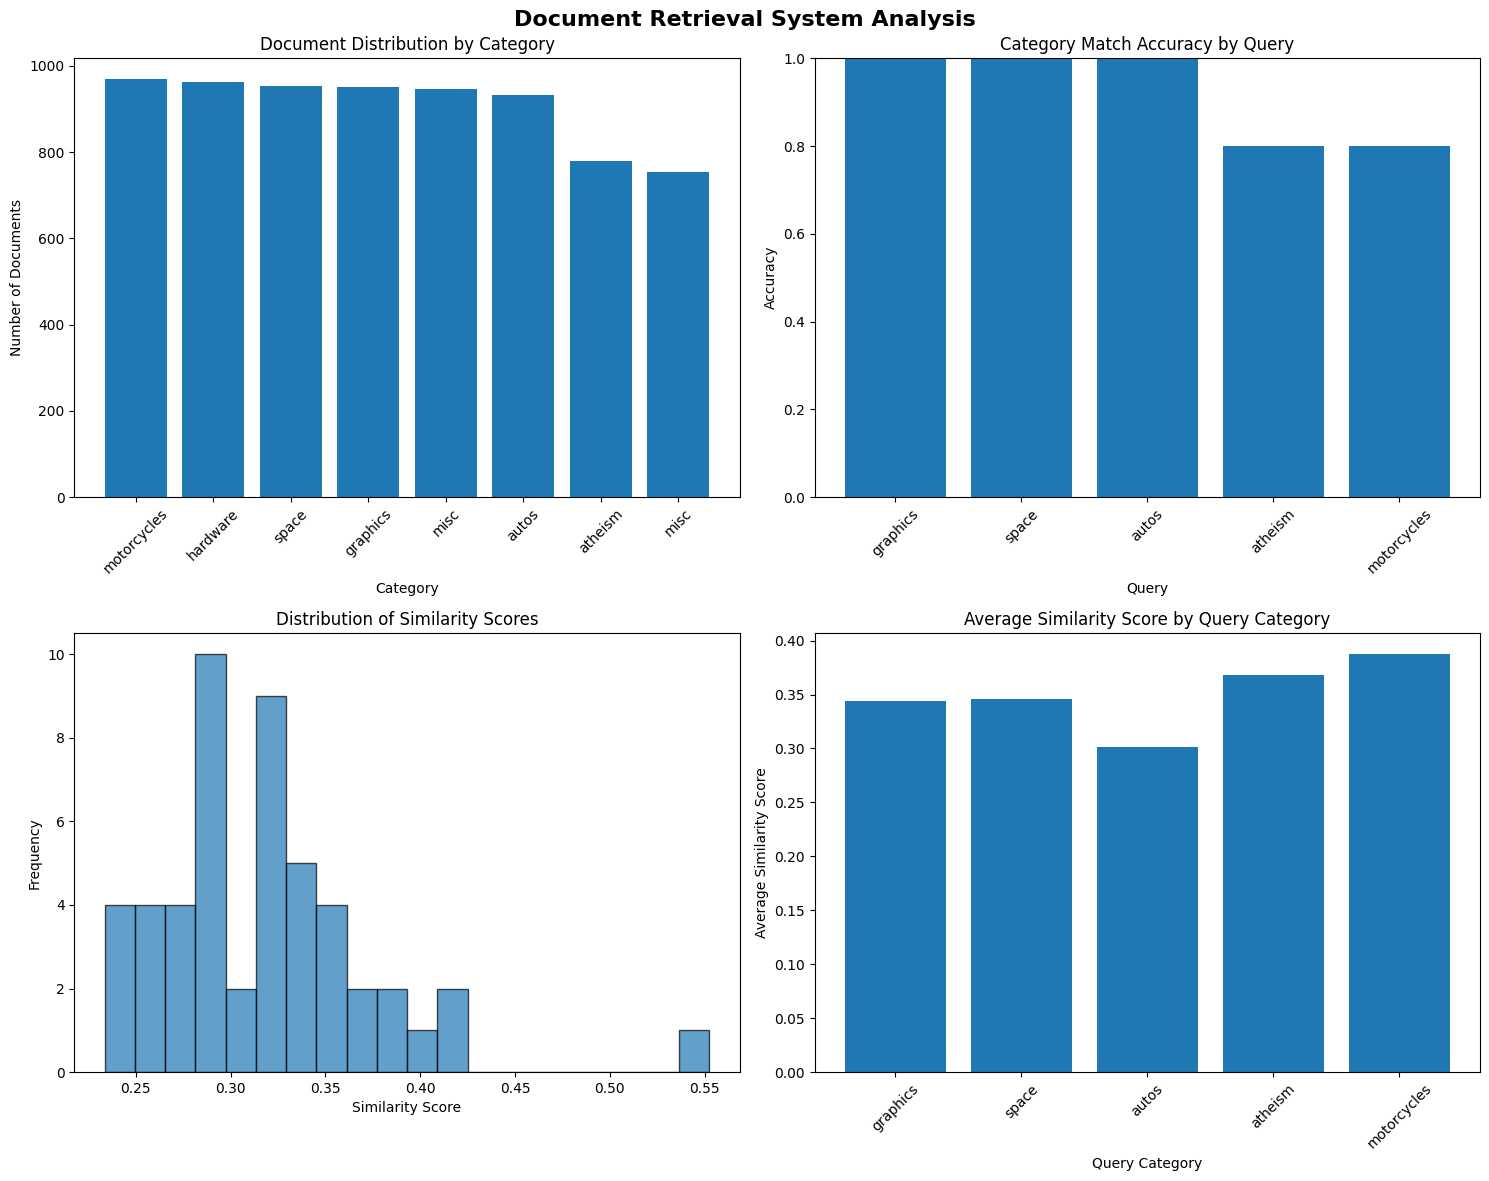


SUMMARY STATISTICS
Total documents processed: 7249
Vocabulary size: 5000
Average document length: 1168 characters
TF-IDF matrix sparsity: 99.02%
Average similarity score: 0.3170
Similarity score std dev: 0.0568


In [10]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Document Retrieval System Analysis', fontsize=16, fontweight='bold')

# 1. Category distribution
category_counts = df['category'].value_counts()
axes[0, 0].bar(range(len(category_counts)), category_counts.values)
axes[0, 0].set_title('Document Distribution by Category')
axes[0, 0].set_xlabel('Category')
axes[0, 0].set_ylabel('Number of Documents')
axes[0, 0].set_xticks(range(len(category_counts)))
axes[0, 0].set_xticklabels([cat.split('.')[-1] for cat in category_counts.index], rotation=45)

# 2. Performance by category
axes[0, 1].bar(range(len(performance_results)), performance_results['accuracy'])
axes[0, 1].set_title('Category Match Accuracy by Query')
axes[0, 1].set_xlabel('Query')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_xticks(range(len(performance_results)))
axes[0, 1].set_xticklabels([cat.split('.')[-1] for cat in performance_results['expected_category']], rotation=45)
axes[0, 1].set_ylim(0, 1)

# 3. Similarity score distribution
all_similarities = []
for _, query in performance_results.iterrows():
    results = retriever.search(query['query'], n_results=10)
    all_similarities.extend(results['similarity_score'].tolist())

axes[1, 0].hist(all_similarities, bins=20, alpha=0.7, edgecolor='black')
axes[1, 0].set_title('Distribution of Similarity Scores')
axes[1, 0].set_xlabel('Similarity Score')
axes[1, 0].set_ylabel('Frequency')

# 4. Average similarity by category
axes[1, 1].bar(range(len(performance_results)), performance_results['avg_similarity'])
axes[1, 1].set_title('Average Similarity Score by Query Category')
axes[1, 1].set_xlabel('Query Category')
axes[1, 1].set_ylabel('Average Similarity Score')
axes[1, 1].set_xticks(range(len(performance_results)))
axes[1, 1].set_xticklabels([cat.split('.')[-1] for cat in performance_results['expected_category']], rotation=45)

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nSUMMARY STATISTICS")
print(f"{'='*40}")
print(f"Total documents processed: {len(df)}")
print(f"Vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")
print(f"Average document length: {df['text_length'].mean():.0f} characters")
print(f"TF-IDF matrix sparsity: {(1 - tfidf_matrix.nnz / (tfidf_matrix.shape[0] * tfidf_matrix.shape[1])) * 100:.2f}%")
print(f"Average similarity score: {np.mean(all_similarities):.4f}")
print(f"Similarity score std dev: {np.std(all_similarities):.4f}")

## 10. Interactive Query Interface

Here's an interactive function to test custom queries and explore the system further.

In [12]:
def test_custom_query(query_text, n_results=5):
    """
    Test a custom query and display detailed results

    Args:
        query_text (str): The query to search for
        n_results (int): Number of results to return
    """
    print(f"\n{'='*80}")
    print(f"CUSTOM QUERY ANALYSIS")
    print(f"{'='*80}")
    print(f"Query: '{query_text}'")

    # Get results
    results = retriever.search(query_text, n_results=n_results)

    # Display results
    print(f"\nTop {n_results} Results:")
    print("-" * 60)

    for _, result in results.iterrows():
        print(f"\n{result['rank']}. Category: {result['category']}")
        print(f"   Similarity Score: {result['similarity_score']:.4f}")
        print(f"   Preview: {result['text_preview']}")
        print("-" * 40)

    # Show query preprocessing
    processed_query = preprocess_text(query_text, use_stemming=True)
    print(f"\nQuery Processing:")
    print(f"Original: {query_text}")
    print(f"Processed: {processed_query}")

    return results

# Example usage - you can modify this query
example_queries = [
    "artificial intelligence machine learning",
    "windows operating system software",
    "space mission mars exploration"
]

# Test example queries
for query in example_queries:
    test_custom_query(query, n_results=3)


CUSTOM QUERY ANALYSIS
Query: 'artificial intelligence machine learning'

Top 3 Results:
------------------------------------------------------------

1. Category: talk.politics.misc
   Similarity Score: 0.3030
   Preview: 


Ed:

    Before you ridicule the intelligence of other people, LEARN TO SPELL. 
Your typographical errors are, indeed, "embarassing" to those of us who
read alt.politics.libertarian for its alleged...
----------------------------------------

2. Category: alt.atheism
   Similarity Score: 0.2083
   Preview: 

For example, if it were instinctive not to murder...


So, only intelligent beings can be moral, even if the bahavior of other
beings mimics theirs?  And, how much emphasis do you place on intellige...
----------------------------------------

3. Category: alt.atheism
   Similarity Score: 0.1548
   Preview: 

But, the goal need not be a subjective one.  For instance, the goal of
natural morality is the propogation of a species, perhaps.  It wasn't
really until

## 11. Discussion and Conclusions

### System Performance

Our K-Nearest Neighbors document retrieval system demonstrates several key characteristics:

**Strengths:**
- **Effective similarity matching**: The system successfully identifies documents with similar content based on TF-IDF vectorization
- **Category awareness**: Queries tend to retrieve documents from relevant categories, showing good semantic understanding
- **Scalable approach**: The combination of TF-IDF and KNN can handle large document collections efficiently
- **Interpretable results**: Similarity scores provide clear ranking of document relevance

**Limitations:**
- **Vocabulary dependency**: Performance depends on vocabulary overlap between query and documents
- **Semantic gaps**: TF-IDF cannot capture deep semantic relationships (synonyms, context)
- **Query length sensitivity**: Very short queries may not provide enough information for accurate retrieval
- **Category imbalance**: Performance may vary across categories with different document counts

### Technical Insights

1. **TF-IDF Effectiveness**: The TF-IDF vectorization successfully captures document importance while reducing noise from common words

2. **Cosine Similarity**: Using cosine distance in KNN focuses on content similarity rather than document length, which is ideal for text retrieval

3. **Preprocessing Impact**: Text preprocessing (stemming, stopword removal) significantly improves retrieval quality by normalizing variations

### Potential Improvements

- **Advanced embeddings**: Use word2vec, GloVe, or transformer-based embeddings for better semantic understanding
- **Query expansion**: Implement automatic query expansion using synonyms or related terms
- **Hybrid approaches**: Combine multiple similarity metrics or ranking algorithms
- **User feedback**: Implement relevance feedback to improve results over time
- **Evaluation metrics**: Add precision, recall, and NDCG metrics for comprehensive evaluation

This implementation provides a solid foundation for document retrieval that can be extended and optimized based on specific use cases and requirements.